# MTH3302 - Méthodes probabilistes et statistiques pour I.A.
#### Polytechnique Montréal


### Projet A2025

----
### Contexte
Le béton est le matériau le plus important en génie civil. La résistance à la compression du béton est une fonction fortement non linéaire de son âge et de ses constituants. Ces constituants comprennent le ciment, le laitier de haut fourneau, les cendres volantes, l’eau, le superplastifiant, les gros granulats et les granulats fins.

Pour ce concours, nous avons accès à une vraie banque de données répertoriant la résistance à la compression du béton en fonction de ses constituants. Ces données ont déjà été analysées avec des réseaux de neurones dans plusieurs articles scientifiques, notamment Chen (1998).

### Objectif
L'objectif principal est de développer un modèle statistique permettant la prédiction de la résistance à la compression (**Strength**) des 330 recettes de l'ensemble de test, en fonction de leurs caractéristiques et de leur âge.

### Description des Données
Les données sont réparties en deux fichiers :
- `train.csv` : 700 recettes avec la résistance connue (Ensemble d'entraînement).
- `test.csv` : 330 recettes dont la résistance est à prédire.

# **1. Chargement des données**

Dans un premier temps, nous importons les librairies nécessaires à l'analyse et à la modélisation ainsi que les données de test et d'entrainement.

In [6]:
using CSV, DataFrames, Statistics, Plots, LinearAlgebra, Random, Measures, GLM

default(size=(800, 500), margin=5Plots.mm)

## 1.1 Chargement des données d'entraînement et de test
Nous chargeons les fichiers CSV dans des DataFrames pour faciliter leur manipulation.

In [7]:
train_df = CSV.read("data/train.csv", DataFrame)
test_df = CSV.read("data/test.csv", DataFrame)

println("Dimensions Train : ", size(train_df))
println("Dimensions Test  : ", size(test_df))

first(train_df, 5)

Dimensions Train : (700, 10)
Dimensions Test  : (330, 9)


5×10 DataFrame
 Row │ ID     Cement   Slag     Ash      Water    Superplasticizer  Coarse   F ⋯
     │ Int64  Float64  Float64  Float64  Float64  Float64           Float64  F ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1    102.0    153.0      0.0    192.0               0.0    887.0    ⋯
   2 │     2    153.0    102.0      0.0    192.0               0.0    888.0
   3 │     3    141.3    212.0      0.0    203.5               0.0    971.8
   4 │     4    183.9    122.6      0.0    203.5               0.0    959.2
   5 │     5    385.0      0.0      0.0    186.0               0.0    966.0    ⋯
                                                               3 columns omitted

## 1.2 Vérification de la qualité des données

Nous vérifions ensuite s'il existe des valeurs manquantes qui pourraient gêner l'analyse et la prédiction de la résistance du béton.

In [24]:
describe(train_df)

10×7 DataFrame
 Row │ variable          mean       min     median   max     nmissing  eltype  ⋯
     │ Symbol            Float64    Real    Float64  Real    Int64     DataTyp ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ ID                350.5        1       350.5   700           0  Int64   ⋯
   2 │ Cement            283.868    102.0     277.0   540.0         0  Float64
   3 │ Slag               74.8664     0.0      24.0   359.4         0  Float64
   4 │ Ash                53.7016     0.0       0.0   200.0         0  Float64
   5 │ Water             181.207    121.8     185.0   246.9         0  Float64 ⋯
   6 │ Superplasticizer    6.24386    0.0       6.5    32.2         0  Float64
   7 │ Coarse            973.72     801.0     968.0  1145.0         0  Float64
   8 │ Fine              772.727    594.0     778.5   992.6         0  Float64
   9 │ Age                44.9        1        28.0   365           0  Int64   ⋯
  10 │ Strength           36.3293     4.57     35.2    82.6         0  Float64
                                                                1 column omitted

Nous observons qu'il n'y a aucune donnée manquante car `nmissing = 0` pour toutes les variables. Cela signifie qu'il n'y a aucun traitement à faire.

----


# **2. Exploration des données**




Avant de commencer la modélisation, il est essentiel de visualiser les données pour comprendre la structure du jeu de données et identifier les relations potentielles entre les variables. 

En particulier, cette démarche permet de repérer d’éventuelles tendances, des zones de dispersion ou de regroupements naturels. Cela nous permet d'avoir un premier aperçu des mécanismes susceptibles d’influencer la variable cible. 

### **2.1 Visualisation de chaque feature en fonction de la variable cible**




Nous commençons par examiner la distribution de chaque feature en fonction de la variable cible (la résistance du béton). Cela nous permet d’identifier la nature des relations qui les lient : linéaires, non linéaires, polynomiale, etc. ou au contraire inexistante. 

L'idée est de récupérer le plus d'informations sur des zones de variabilité, des seuils possibles, ou alors des comportements particuliers pouvant influencer la performance du modèle. Cette analyse nous permet de mieux anticiper la pertinence prédictive de chaque variable et de détecter d’éventuelles transformations nécessaires (normalisation, logarithme, etc.).

In [25]:
function plot_features_vs_target(train_df, target_col)
    features = names(train_df)[2:end-1]  # pour exclure ID et Strength
    n_features = length(features)
    
    plots = []    
    for feature in features
        p = scatter(train_df[!, feature], train_df[!, target_col],
                  xlabel=feature, ylabel=target_col,
                  title="$feature vs $target_col",
                  markersize=4, alpha=0.5,
                  legend=false)
        push!(plots, p)
    end

    plot_grid = plot(plots..., layout=(ceil(Int, n_features/3), 3), size=(1300, 1100),
                   left_margin=4mm,
                   right_margin=4mm,
                   top_margin=10mm,
                   bottom_margin=10mm)
    display(plot_grid)
end

plot_features_vs_target(train_df, "Strength")

Nous pouvons observer différentes tendances pour la résistance en fonction de chaque variable : 

- Aucune variable ne présente une tendance linéaire, ce qui laisse penser qu'il va falloir faire de nombreuses transformations. 
- Les variables `Slag`, `Ash` et `Superplasticize` possède un grand nombre d'éléments à `0`, ce que nous allons sûrement devoir prendre en compte.
- La variable `Age` n'est pas linéairement répartie et notamment surreprésentée entre 0 et 100, ce qui fait penser à une transformation logarithmique pour linéariser son comportement.

Pour comprendre plus généralement le pouvoir de prédiction de chaque variable sur la résistance du béton ,nous analysons la corrélation de chaque variable avec la résistance.

In [26]:
function analyze_strength_correlations(train_df)
    features = names(train_df)[2:end-1] 
    correlations = Float64[]    
    for feature in features
        cor_val = cor(train_df[!, feature], train_df.Strength)
        push!(correlations, cor_val)
    end
    
    cor_df = DataFrame(Feature=features, Correlation=correlations)
    sort!(cor_df, :Correlation, rev=true)
    
    println("\nCorrélations avec Strength (triées) :")
    for row in eachrow(cor_df)
        println("$(row.Feature): $(round(row.Correlation, digits=3))")
    end
    
    # graphique des corrélations
    bar_plot = Plots.bar(cor_df.Feature, cor_df.Correlation,
        xlabel="Features", ylabel="Corrélation avec Strength",
        title="Corrélations des features avec Strength",
        legend=false, xrotation=45,
        color=ifelse.(cor_df.Correlation .> 0, :blue, :red),
        size=(800, 400))
    
    
    return bar_plot
end

cor_bar_plot = analyze_strength_correlations(train_df)


Corrélations avec Strength (triées) :
Cement: 0.462
Superplasticizer: 0.419
Age: 0.336
Slag: 0.143
Ash: -0.071
Fine: -0.16
Coarse: -0.167
Water: -0.308

Cement: 0.462
Superplasticizer: 0.419
Age: 0.336
Slag: 0.143
Ash: -0.071
Fine: -0.16
Coarse: -0.167
Water: -0.308


D'après le graphique, il est net que les variables `Ciment`, `Superplasticizer`, `Age` et `Water` ont la corrélation la plus importante avec la résistance du béton et devront être pris en compte dans notre modélisation. 

### **2.2 Interprétation globale de la relation entre les variables et la résistance du béton**

En étudiant les données obtenues pour chaque variable explicative, nous obtenons les observations suivantes concernant leur relation avec la résistance du béton :

| Variable | Type de relation avec la résistance du béton | Tendances clés |
| :--- | :--- | :--- |
| **Ciment** | Corrélation positive | En moyenne, la résistance augmente avec la présence de ciment. Augmentation de la résistance en moyenne avec l'augmentation du Ciment. La dispersion verticale est assez large pour la plupart des niveaux de Ciment.|
| **Age** | Corrélation positive | La résistance augmente avec l'âge mais de manière non linéaire jusqu'à environ 100 jours. |
| **Water** | Corrélation négative moyenne | En moyenne, la résistance diminue avec l'augmentation de la quantité d'Eau. |
| **Slag** | Non-linéaire | La dispersion est trop élevée pour conclure sur le lien entre résistance et la quantité de `Slag`. |
| **Ash** | Non-linéaire | Deux groupes semblent se distinguer entre les valeurs de `Ash` à 0 et les autres mais la dispersion est trop importante pour conclure à cette étape. |
| **Superplasticizer** | Corrélation positive (en enlevant les 0) | Il y a une forte concentration à zéro puis un nuage de points où, en moyenne, l'augmentation de superplasticizer augmente la résistance. |
| **Fine** | Non-linéaire | La dispersion est trop élevée pour conclure sur le lien entre résistance et la quantité de `Fine`. |
| **Coarse** | Non-linéaire | La dispersion est trop élevée pour conclure sur le lien entre résistance et la quantité de `Coarse`. |








### 2.3 Première piste de recherche

#### 2.3.1 Variables booléennes

L'analyse des distributions des variables `Slag`, `Ash` et `Superplasticizer` montre une caractéristique commune : une concentration importante de valeurs à zéro sur l'axe des x. Ces points suggèrent qu'une part significative des recettes de béton enregistrées n'inclut pas ces additifs. 
Il semblerait donc que l'intérêt de ces variables est leur présence ou non dans la recette. Au  lieu de considérer ces variables comme des quantités continues, il pourrait être pertinent de les transformer en variables booléennes.

#### 2.3.2 Variables ayant un besoin de transformation :

Pour apréhender la modélisation des relations comme celle de l'âge avec la force, nous devons appliquer des transformations. L'objectif est de rendre ces relations plus linéaires si nous voulons utiliser la régression linéaire par la suite.

* Pour l' `Age`, dont l'effet diminue avec le temps, la méthode la plus appropriée est la transformation logarithmique ($\log(\text{Âge})$). L'intérêt est qu'elle compresse les grandes valeurs et étire les petites, normalisant ainsi le taux de gain de Force. 

* Par la suite, des transformations polynomiales (ex : $X^2$) pourront être utiles pour capturer des courbures subtiles ou alors des effets de seuil dans des variables comme le ciment. 

On explorera ces différentes pistes.

### **2.4 Détection des valeurs suspectes**

La présence de données aberrantes peut nuire à la qualité d'un modèle de régression, car la méthode des moindres carrés est très sensible aux valeurs extrêmes.

Comme vu au **Chapitre 2 (Section 2.7.5 - Identification des données suspectes)**, nous utilisons les résidus studentisés ($s_i$) pour identifier ces observations.

#### 2.4.1 Méthodologie Théorique

Le résidu studentisé interne est défini par :
$$s_i = \frac{e_i}{\sqrt{\hat{\sigma}^2 (1 - h_i)}}$$

Où :
* $e_i = y_i - \hat{y}_i$ est le résidu ordinaire.
* $\hat{\sigma}^2$ est l'estimateur sans biais de la variance de l'erreur (**Chapitre 2, Éq 2.4**).
* $h_i$ est le levier de l'observation $i$ (élément diagonal de la matrice chapeau $H = X(X^\top X)^{-1}X^\top$).

**Critère de rejet :** Une observation est considérée comme suspecte si $|s_i| > 3$.

#### 2.4.2 Implémentation 
Nous implémentons le calcul matriciel pour trouver les valeurs suspectes.

In [8]:
# fonction pour calculer les résidus studentisés
function detect_outliers(X, y)
    X_mat = Matrix(X)
    n, p = size(X_mat)
    
    X_design = hcat(ones(n), X_mat) 

    beta_hat = (X_design' * X_design) \ (X_design' * y) # estimation des coefficients (MCO)
    
    y_hat = X_design * beta_hat
    residuals = y - y_hat
    
    n, p_design = size(X_design)
    sigma2_hat = sum(residuals.^2) / (n - p_design)
    
    XtX_inv = inv(X_design' * X_design)
    h = [ (X_design[i,:]' * XtX_inv * X_design[i,:]) for i in 1:n ]
    
    studentized = residuals ./ sqrt.(sigma2_hat .* (1 .- h))
    
    return studentized
end

features_cols = [:Cement, :Slag, :Ash, :Water, :Superplasticizer, :Coarse, :Fine, :Age]
X_check = train_df[:, features_cols]
y_check = train_df.Strength

residus_stud = detect_outliers(X_check, y_check)

# Identification des indices dépassant le seuil critique de 3
outliers_indices = findall(abs.(residus_stud) .> 3)

println("Nombre d'outliers détectés (|s_i| > 3) : ", length(outliers_indices))
println("Indices des observations à retirer : ", outliers_indices)

Nombre d'outliers détectés (|s_i| > 3) : 2
Indices des observations à retirer : [188, 699]


On veut visualiser l'identification des données suspectes : 

In [28]:
scatter(residus_stud, label="Résidus Studentisés", legend=:topright,
        title="Identification des Données Suspectes", 
        xlabel="Index de l'observation", ylabel="Résidu Studentisé")
hline!([3, -3], color=:red, linestyle=:dash, label="Seuil critique")

#### 2.4.3 Suppression des observations aberrantes

Suite à cette analyse et au critère $|s_i| > 3$, nous retirons ces observations de l'ensemble d'entraînement. Ces points risquent de correspondre à des erreurs de mesure ou à des bétons aux propriétés exceptionnelles non représentatives de la population générale. Les conserver risquerait de biaiser notre modèle, particulièrement lors de l'utilisation de polynômes de degré élevé.

In [9]:
# Création du jeu de données nettoyé
df_train_clean = train_df[setdiff(1:nrow(train_df), outliers_indices), :]

println("Taille initiale : ", size(train_df))
println("Taille après nettoyage : ", size(df_train_clean))

Taille initiale : (700, 10)
Taille après nettoyage : (698, 10)


### **2.5 Analyse des doublons exacts**

En explorant les données, nous avons remarqué plusieurs lignes identiques (mêmes ingrédients (X) et même résistance (Y)).

Plutôt que de les supprimer aveuglément, nous avons testé l'impact de leur suppression. En testant, nous avons remarqué que le modèle performe moins bien sans ces lignes.

Mathématiquement, cela s'explique par la méthode des **Moindres Carrés** utilisée en régression (Chapitre 2). La fonction de coût que le modèle cherche à minimiser est :
$$SS_E = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

Si une recette apparaît 4 fois (ex: 693 à 696), elle pèse 4 fois plus lourd dans cette somme. En conservant ces doublons, on force le modèle à être plus précis sur ces recettes qui sont fréquentes dans la réalité. Les supprimer reviendrait à dire au modèle que ces cas sont moins importants qu'ils ne le sont vraiment, ce qui augmente l'erreur globale.



In [23]:
cols_features = names(df_train_clean, Not(:ID))
doublons_mask = nonunique(df_train_clean, cols_features)
nb_doublons = sum(doublons_mask)

grouped_df = groupby(train_df, cols_features)
duplicate_groups = filter(x -> nrow(x) > 1, grouped_df)
display(first(DataFrame(duplicate_groups), 5))
print("Nombre de doublons: ", nb_doublons)

5×10 DataFrame
 Row │ ID     Cement   Slag     Ash      Water    Superplasticizer  Coarse   F ⋯
     │ Int64  Float64  Float64  Float64  Float64  Float64           Float64  F ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │   116    252.0      0.0      0.0    185.0               0.0   1111.0    ⋯
   2 │   117    252.0      0.0      0.0    185.0               0.0   1111.0
   3 │   319    425.0    106.3      0.0    153.5              16.5    852.1
   4 │   320    425.0    106.3      0.0    153.5              16.5    852.1
   5 │   323    425.0    106.3      0.0    153.5              16.5    852.1    ⋯
                                                               3 columns omitted

Nombre de doublons: 14

Nous avons comparé la performance du modèle sur le jeu de test (Kaggle) dans deux configurations :
1.  **Conservation des doublons :** Score de **4.96804**.
2.  **Suppression des doublons :** Score de **5.07266**.

Nous décidons donc de conserver ces doublons exacts.

---

# **3. Ingénierie des fonctionnalités (Feature Engineering)**

Les analyses effectuées aux sections précédentes (1, 2 et 3) ont mis en évidence trois constats majeurs qui orientent notre stratégie de modélisation :
1.  **Forte non-linéarité :** La relation entre les constituants et la résistance n'est pas linéaire (ex: l'effet de l'âge s'estompe avec le temps).
2.  **Interactions chimiques :** L'impact de l'eau dépend de la quantité de ciment (ratio Eau/Ciment). Traiter ces variables isolément serait une erreur physique.
3.  **Multicolinéarité :** Certaines variables sont corrélées entre elles (ex: Eau et Superplastifiant). Plutôt que de les supprimer, nous allons les combiner en ratios significatifs.

Pour capturer cette complexité, nous avons développé un pipeline de transformation en deux étapes : une transformation **physique** (basée sur la connaissance métier du génie civil) suivie d'une expansion **polynomiale**.

## 3.1 Intégration des lois physiques du béton

Le béton n'est pas un simple mélange additif. En effet, sa résistance suit des lois empiriques connues (comme la loi de Abrams). Nous avons implémenté une fonction `physics_transform` qui crée des variables synthétiques pour mieux guider le modèle.

Afin de sélectionner les transformations les plus pertinentes à ajouter à notre modèle, nous allons calculer leur coefficient de corrélation de Pearson avec la variable cible (`Strength`). Cette approche quantitative nous permet de comparer l'efficacité des nouvelles variables par rapport aux données brutes et de ne conserver que celles qui améliorent la linéarité du problème.

Nous allons utiliser nos données sans les observations aberrantes.

### 3.1.1 Transformation Temporelle

Comme observé en section 2.2, la résistance du béton n'augmente pas linéairement avec le temps (âge). La réaction d'hydratation est violente les premiers jours (gain rapide) puis ralentit asymptotiquement.

Alors, nous appliquons une transformation logarithmique : $x' = \log(Age + 1)$. Le $+1$ permet de gérer les bétons frais (Age=0) et d'éviter $\log(0)$.

In [10]:
age_raw = df_train_clean.Age
log_age = log.(age_raw .+ 1)

println("Corrélation Age brut : ", round(cor(age_raw, df_train_clean.Strength), digits=3))
println("Corrélation Log Age  : ", round(cor(log_age, df_train_clean.Strength), digits=3), " (Amélioration)")

Corrélation Age brut : 0.351
Corrélation Log Age  : 0.572 (Amélioration)


Alors, en plus des variables de base, il serait pertinent d’ajouter le logarithme de l’âge.

### 3.1.2 Création de Ratios (Inspirés par la loi de Abrams)

En nous documentant sur le fonctionnement du béton (**Loi de Abrams**), nous avons compris que la résistance ne dépend pas juste des quantités brutes, mais des proportions entre les ingrédients.

Pour tester cette hypothèse, nous avons d'abord regroupé les matériaux qui collent :

**Les Liants ($Binder$)** : Tout ce qui colle (Ciment + Laitier + Cendres).

$$\text{Binder} = \text{Cement} + \text{Slag} + \text{Ash}$$

Ensuite, nous avons décidé de tester **5 ratios** qui nous semblaient pertinents physiquement :

**1. Ratio Eau / Liant ($W/B$) :**
C'est l'application généralisée de la loi de Abrams. Plus il y a d'eau par rapport à la masse totale de poudre (liant), moins la matrice est dense et solide.
$$\text{Ratio}_{W/B} = \frac{\text{Water}}{\text{Binder} + 1}$$

**2. Ratio Eau / Ciment ($W/C$) :**
C'est la forme originale de la loi. Nous avons ajouté ce ratio spécifique, car le ciment est le composant le plus réactif. Cela permet au modèle de distinguer l'effet de l'eau sur le ciment pur par rapport aux autres liants moins réactifs.
$$\text{Ratio}_{W/C} = \frac{\text{Water}}{\text{Cement} + 1}$$

**3. Ratio Gros / Fins ($Coarse/Fine$) :**
C'est une question d'empilement granulaire (compacité). Il faut un bon équilibre entre les gros et les petits grains pour minimiser les vides. Nous avons créé ce ratio pour capturer cet effet géométrique.
$$\text{Ratio}_{C/F} = \frac{\text{Coarse}}{\text{Fine} + 1}$$

**4. Efficacité du Superplastifiant ($Sp/C$) :**
Le superplastifiant sert à disperser les grains de ciment pour réduire le besoin en eau. Nous avons créé ce ratio pour mesurer son efficacité relative par rapport à la quantité de ciment à traiter.
$$\text{Ratio}_{Sup/Cem} = \frac{\text{Superplasticizer}}{\text{Cement} + 1}$$

In [11]:
features = [:Cement, :Slag, :Ash, :Water, :Superplasticizer, :Coarse, :Fine]
M = Matrix(df_train_clean[:, features])
target = df_train_clean.Strength

total_binder = M[:, 1] .+ M[:, 2] .+ M[:, 3] 

w_b = M[:, 4] ./ (total_binder .+ 1.0)     
w_c = M[:, 4] ./ (M[:, 1] .+ 1.0)         
c_f = M[:, 6] ./ (M[:, 7] .+ 1.0)       
sup_cem = M[:, 5] ./ (M[:, 1] .+ 1.0)       

println("--- 1. Test avec l'eau ---")
println("Eau brute (Water)          : ", round(cor(M[:, 4], target), digits=3))
println("Ratio W/B (Eau/Liant)      : ", round(cor(w_b, target), digits=3))
println("Ratio W/C (Eau/Ciment)     : ", round(cor(w_c, target), digits=3))

println("\n--- 2. C/F ---")
println("Coarse brut                : ", round(cor(M[:, 6], target), digits=3))
println("Ratio C/F                  : ", round(cor(c_f, target), digits=3))

println("\n--- 3. Sup/Cem ---")
println("Superplastifiant brut      : ", round(cor(M[:, 5], target), digits=3))
println("Ratio Sup/Cem              : ", round(cor(sup_cem, target), digits=3))

println("\n--- 4. Binder ---")
println("total_binder               : ", round(cor(total_binder, target), digits=3))



--- 1. Test avec l'eau ---
Eau brute (Water)          : -0.303
Ratio W/B (Eau/Liant)      : -0.623
Ratio W/C (Eau/Ciment)     : -0.485

--- 2. C/F ---
Coarse brut                : -0.177
Ratio C/F                  : 0.036

--- 3. Sup/Cem ---
Superplastifiant brut      : 0.421
Ratio Sup/Cem              : 0.196

--- 4. Binder ---
total_binder               : 0.604


Alors, les ratios W/B et W/C seront ajoutés, puisqu’ils offrent une information additionnelle utile concernant la composante eau. Nous allons aussi ajouter binder. Par contre, les ratios C/F et Sup/Cem ne seront pas ajoutés, car ils n’apportent pas d’information supplémentaire par rapport aux variables brutes correspondantes.

### 3.1.3 Interactions Temporelles (Couplage Matière-Temps)

L'âge ($Age$) n'est pas une variable indépendante : il agit comme un multiplicateur sur les matériaux réactifs. Cependant, chaque matériau a sa propre cinétique d'hydratation :
* **Ciment :** Réaction rapide (court terme).
* **Laitier (Slag) et Cendres (Ash) :** Réaction pouzzolanique lente (long terme).
* **Eau :** Son impact négatif peut évoluer avec le séchage.

Pour modéliser cela, nous créons des termes de couplage explicites :
$$Interaction_{i} = \text{Matériau}_i \times \log(Age + 1)$$

In [12]:

cem_age = M[:, 1] .* log_age
slag_age = M[:, 2] .* log_age
ash_age = M[:, 3] .* log_age
water_age = M[:, 4] .* log_age

println("--- Impact du couplage temps/matière ---")
println("Ciment seul (Cement)           : ", round(cor(M[:, 1], df_train_clean.Strength), digits=3))
println("Interaction Ciment x Temps     : ", round(cor(cem_age, df_train_clean.Strength), digits=3))
println("")
println("Laitier seul (Slag)            : ", round(cor(M[:, 2], df_train_clean.Strength), digits=3))
println("Interaction Laitier x Temps    : ", round(cor(slag_age, df_train_clean.Strength), digits=3))
println("")
println("Laitier seul (Ash)            : ", round(cor(M[:, 3], df_train_clean.Strength), digits=3))
println("Interaction Cendre x Temps    : ", round(cor(ash_age, df_train_clean.Strength), digits=3))
println("")
println("Eau seul (Water)               : ", round(cor(M[:, 4], df_train_clean.Strength), digits=3))
println("Interaction Eau x Temps        : ", round(cor(water_age, df_train_clean.Strength), digits=3))

--- Impact du couplage temps/matière ---
Ciment seul (Cement)           : 0.463
Interaction Ciment x Temps     : 0.701

Laitier seul (Slag)            : 0.141
Interaction Laitier x Temps    : 0.311

Laitier seul (Ash)            : -0.069
Interaction Cendre x Temps    : 0.043

Eau seul (Water)               : -0.303
Interaction Eau x Temps        : 0.412


Nous avons décidé d’ajouter l’interaction entre l’eau et le temps, puisqu’elle présente une corrélation notable (0.412).

Plutôt que d’utiliser uniquement le logarithme de l’âge avec le ciment et le laitier, nous avons créé une variable supplémentaire (section 4.1.4) afin de capter l’ensemble des corrélations positives liées aux interactions temps/matière.

Par ailleurs, nous n’ajoutons pas l’interaction Cendre × Âge, car sa corrélation est faible et n’apporte pas d’information supplémentaire pertinente au modèle.

### 3.1.4 Interaction trouvée (Golden)
Nous avons décidé de créer une variable avec les corrélations positives. Au lieu de simplement les multiplier, on a utilisé des facteurs conditionnels pour gérer les valeurs nulles. D'abord, comme vu plus haut (4.1.3), nous avons vu que le ciment * log(age) donnait une haute corrélation (0.701).

Comme mentionné dans la partie 2.2, nous avons observé une distribution particulière pour les variables Slag (Laitier) et Superplasticizer. Elles contiennent une très forte proportion de zéros (absence de l'additif dans le mélange). Si on multipliait directement par ces variables, on obtiendrait une résistance de 0 pour la majorité des lignes, ce qui n'a pas de sens.

C'est pour cela que nous avons décidé de tester cette interaction :
$$
\text{Interaction} = \text{Ciment} \times (1 + \mathbb{1}_{\text{Slag}>0}) \times (1 + \mathbb{1}_{\text{Super}>0}) \times \log(\text{Age})
$$


In [13]:
has_slag = Float64.(M[:, 2] .> 0)
has_super = Float64.(M[:, 5] .> 0)
golden = M[:, 1] .* log_age .* (1.0 .+ has_slag) .* (1.0 .+ has_super)
println("Corrélation interaction trouvée : ", round(cor(golden, df_train_clean.Strength), digits=3))

Corrélation interaction trouvée : 0.802


C'est notre meilleur corrélation trouvée, donc nous allons l'ajouter à nos variables. Nous allons la nommer "golden".

### 3.1.5 Modèle de Féret Volumétrique 

Une adaptation de la célèbre loi de Féret qui relie la résistance au volume absolu de ciment par rapport aux fluides et vides.
    $$Féret = \left( \frac{V_{ciment}}{V_{ciment} + V_{eau} + V_{air}} \right)^2$$
    


In [14]:
feret = (M[:, 1] ./ (M[:, 1] .+ M[:, 4] .+ 0.1)) .^ 2

println("Corrélation Féret : ", round(cor(feret, df_train_clean.Strength), digits=3))

Corrélation Féret : 0.528


### 3.1.6 Sélection Finale et Pipeline de Transformation

**Synthèse des analyses :**
Suite à l'étude des corrélations effectuée dans les sections 4.1.1 à 4.1.5, nous avons identifié un ensemble de transformations qui capturent mieux la variance de la résistance.

**Sélection des Variables :**
Notre modèle final intègre les variables `log_age`, `feret`, `golden` ainsi que les interactions liées à l'eau (`w_b`, `w_c`, `w_a`). 

Nous définissons ici la fonction `physics_transform` définitive. Cette fonction sera appliquée aux données d'entraînement (train) et de test (test) pour garantir la cohérence du pipeline.

In [25]:
function physics_transform(M::Matrix)
    # Indices: Cement=1, Slag=2, Ash=3, Water=4, Super=5, Coarse=6, Fine=7, Age=8
    log_age = log.(M[:, 8] .+ 1)

    binder = M[:, 1] .+ M[:, 2] .+ M[:, 3]
    w_b = M[:, 4] ./ (binder .+ 1.0)     
    w_c = M[:, 4] ./ (M[:, 1] .+ 1.0)
    w_a = M[:, 4] .* log_age

    feret = (M[:, 1] ./ (M[:, 1] .+ M[:, 4] .+ 0.1)) .^ 2

    has_slag = Float64.(M[:, 2] .> 0)
    has_super = Float64.(M[:, 5] .> 0)
    golden = M[:, 1] .* log_age .* (1.0 .+ has_slag) .* (1.0 .+ has_super)
    
    return hcat(M[:, 1:7], log_age, binder, w_b, w_c, w_a, feret, golden)
end

physics_transform (generic function with 1 method)

## 3.2 Expansion Polynomiale

Même avec nos variables physiques, la régression linéaire a une limite majeure, car elle trace des lignes droites. Or, dans la chimie du béton, les relations forment souvent des courbes.

Comme vu au Chapitre 2 du cours, nous pouvons modéliser ces relations complexes tout en gardant un modèle linéaire simplement en ajoutant des puissances de nos variables.

Notre fonction `expand_poly` transforme nos données pour ajouter :

1.  **Des termes au carré ($x^2$) :** Pour capter les effets paraboliques
2.  **Des termes au cube ($x^3$) :** Pour modéliser les changements de courbure
3.  **Des interactions ($x_i \cdot x_j$) :** Pour voir si l'effet d'un ingrédient change selon la quantité d'un autre 

Enfin, le code ajoute une colonne remplie de "1". C'est ce qui permet au modèle de calculer l'ordonnée à l'origine ($\beta_0$) directement dans la matrice.

### 3.2.1 La Fonction d'Expansion

In [16]:
function expand_poly(X::Matrix)
    n_samples, n_features = size(X)
    
    n_out = n_features * 3 + (n_features * (n_features - 1)) ÷ 2
    X_poly = zeros(n_samples, n_out)
    
    col = 1
    
    X_poly[:, col:col+n_features-1] = X
    col += n_features
    
    X_poly[:, col:col+n_features-1] = X .^ 2
    col += n_features
    
    X_poly[:, col:col+n_features-1] = X .^ 3
    col += n_features
    
    for i in 1:n_features
        for j in i+1:n_features
            X_poly[:, col] = X[:, i] .* X[:, j]
            col += 1
        end
    end
    
    return hcat(ones(n_samples), X_poly[:, 1:col-1])
end
# ---

expand_poly (generic function with 1 method)

### 3.2.2 Preuve visuelle de la nécessité du Degré 3

Le graphique ci-dessous compare un ajustement linéaire simple à un ajustement polynomial de degré 3 appliqué à la variable Ratio Eau/Liant. On observe que le modèle cubique suit beaucoup mieux la tendance des données, ce qui justifie l’utilisation d’un polynôme de degré 3.

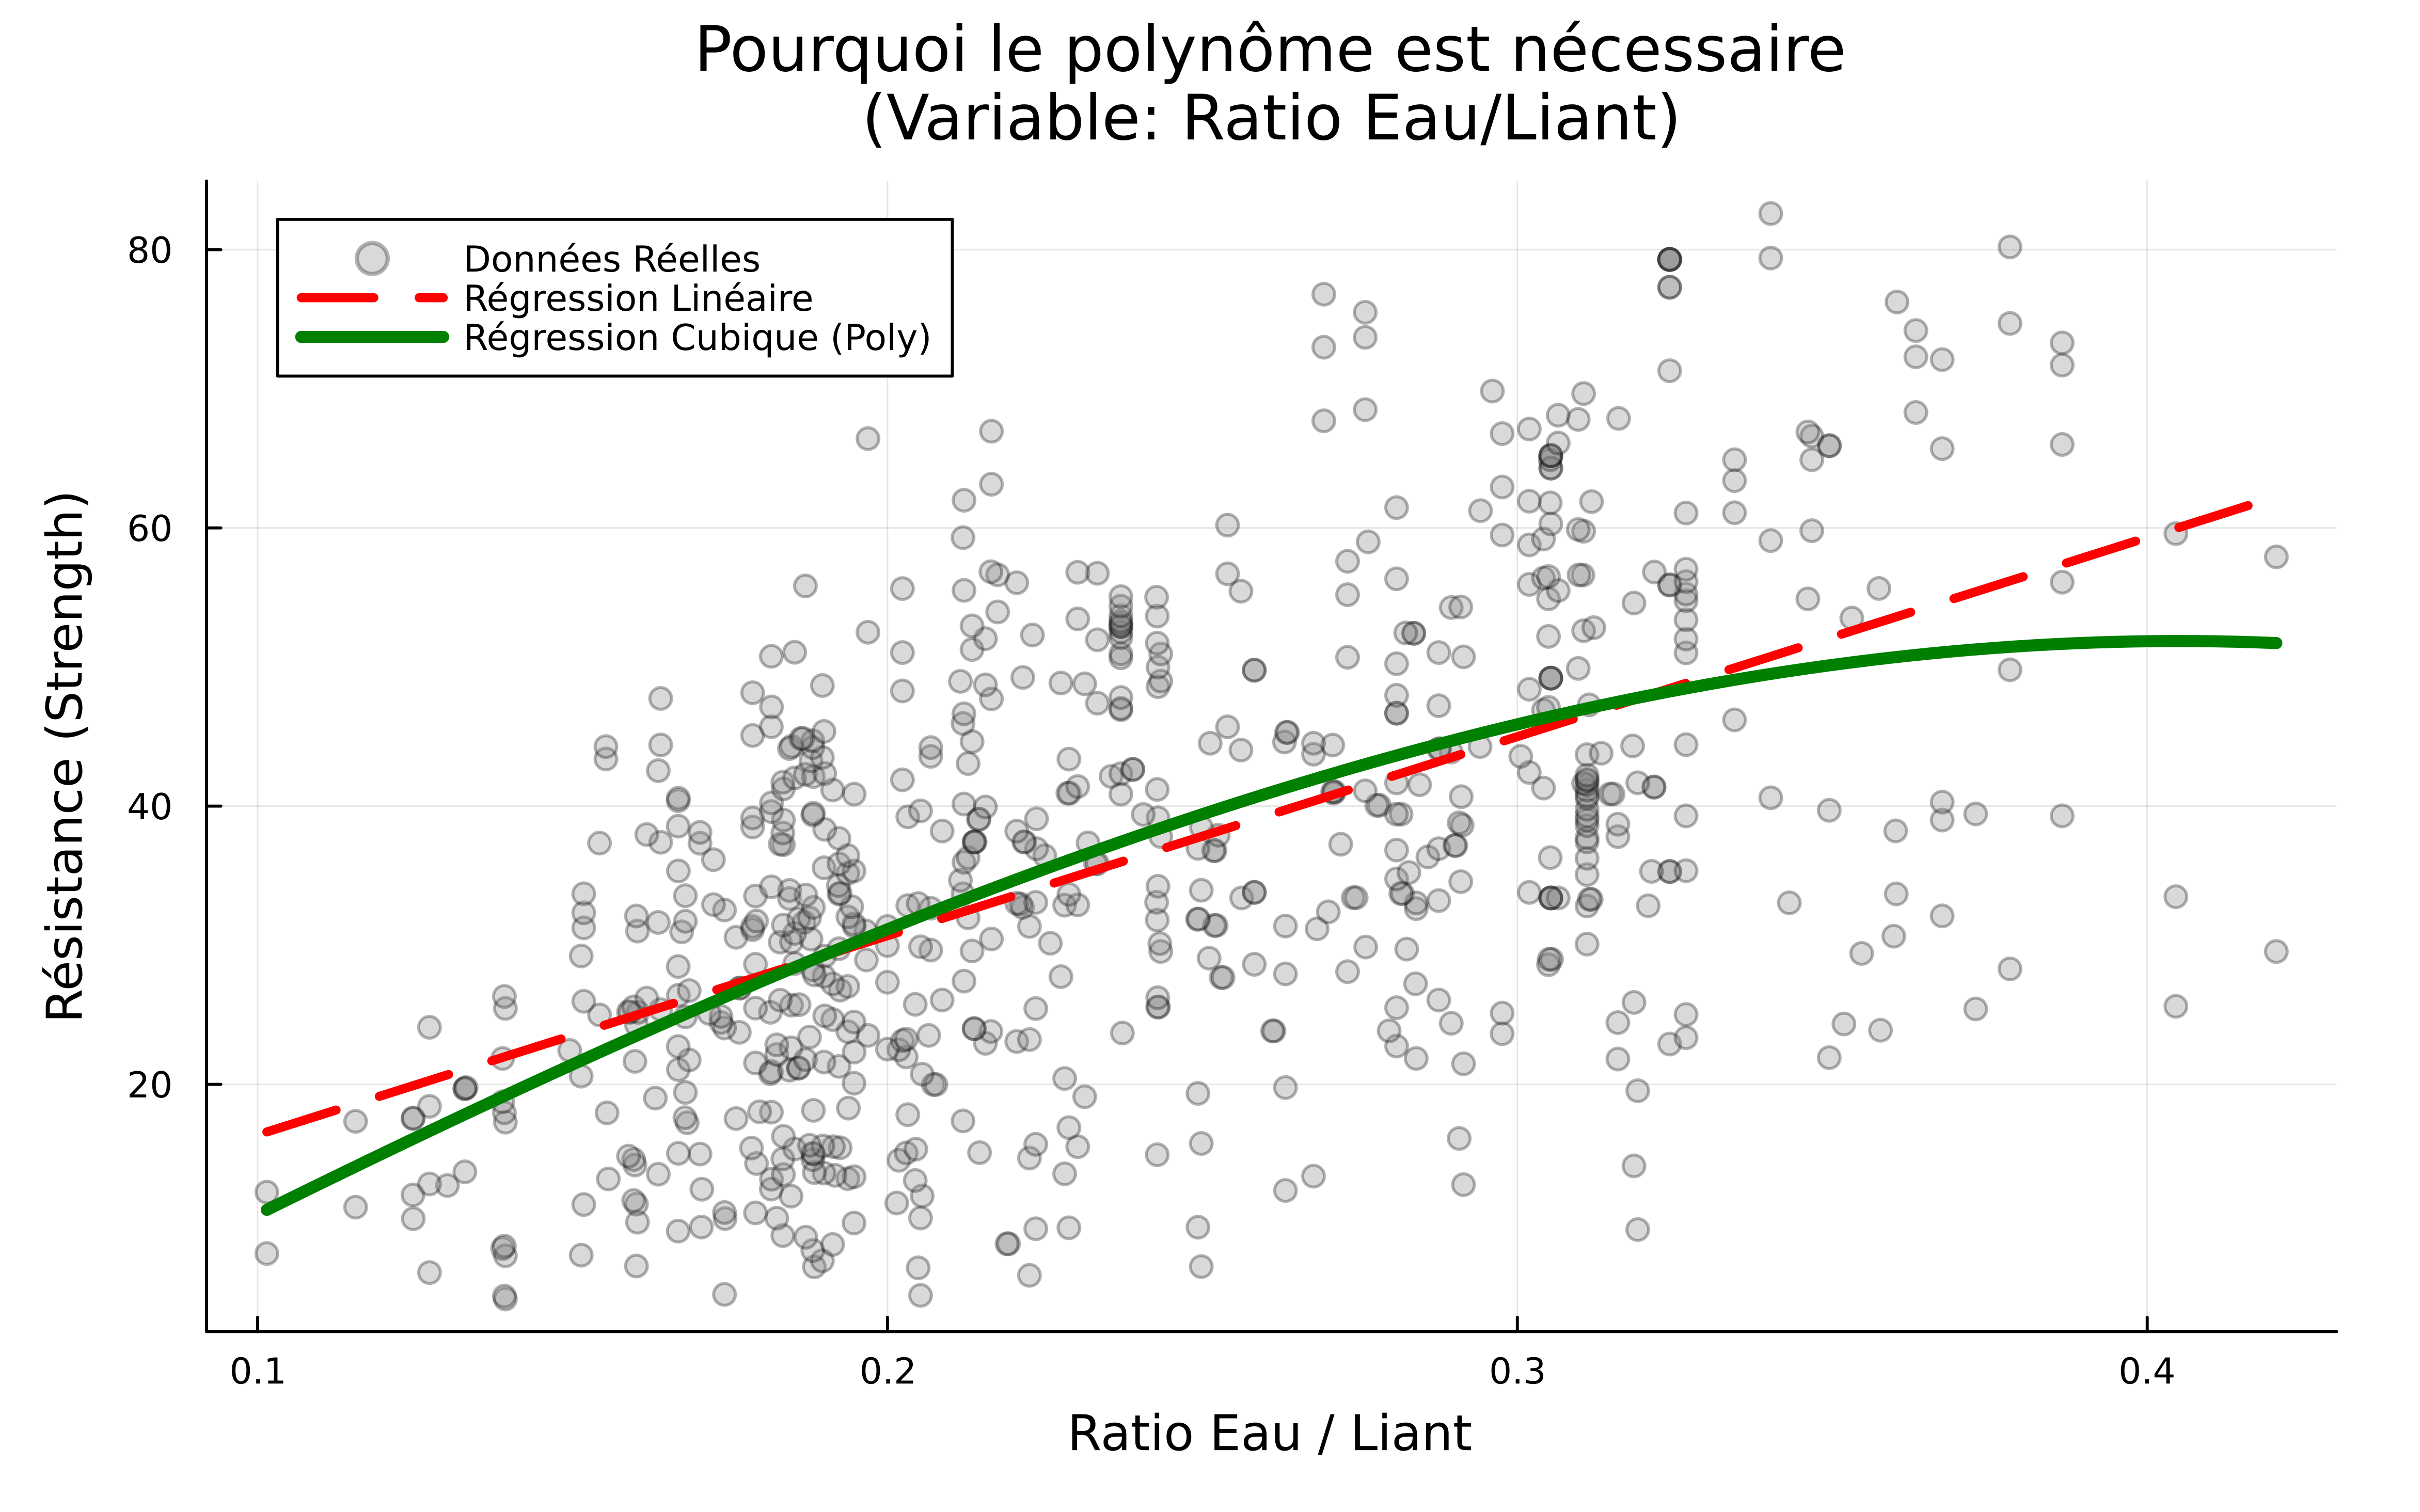

In [24]:

features = [:Cement, :Slag, :Ash, :Water, :Superplasticizer, :Coarse, :Fine, :Age]
X_phys = physics_transform(Matrix(df_train_clean[:, features]))
X_final_train = expand_poly(X_phys)
x_demo = X_phys[:, 10] 
y_demo = df_train_clean.Strength

df_demo = DataFrame(X=x_demo, Y=y_demo)
df_demo.X2 = x_demo .^ 2
df_demo.X3 = x_demo .^ 3


model_lin = lm(@formula(Y ~ X), df_demo)

model_poly = lm(@formula(Y ~ X + X2 + X3), df_demo)

x_range = range(minimum(x_demo), maximum(x_demo), length=100)
df_pred = DataFrame(X=x_range, X2=x_range.^2, X3=x_range.^3)

y_pred_lin = predict(model_lin, df_pred)
y_pred_poly = predict(model_poly, df_pred)

scatter(x_demo, y_demo, label="Données Réelles", alpha=0.3, color=:gray, title="Pourquoi le polynôme est nécessaire\n(Variable: Ratio Eau/Liant)")
plot!(x_range, y_pred_lin, label="Régression Linéaire", color=:red, linewidth=3, linestyle=:dash)
plot!(x_range, y_pred_poly, label="Régression Cubique (Poly)", color=:green, linewidth=4)

xlabel!("Ratio Eau / Liant")
ylabel!("Résistance (Strength)")

___

# **4. Étude de la multicolinéarité**


Suite à l'expansion de notre espace de variables (ajout de polynômes, d'interactions et de ratios), il est important d'évaluer la structure de corrélation de notre matrice de design $X$.

En effet, la création de variables dérivées (comme $x^2$ ou $Ciment \times Age$) introduit mécaniquemen. Une forte corrélation entre les prédicteurs rend la matrice $X^\top X$ mal conditionnée, ce qui peut fausser l'interprétation des coefficients $\hat{\beta}$ et augmenter leur variance.

Avant de procéder à l'entraînement, nous allons quantifier ce phénomène à l'aide du **Facteur d'Inflation de la Variance (VIF)**. Cette analyse nous permettra de confirmer la nécessité d'utiliser une méthode de régularisation (comme la régression Ridge) pour stabiliser le modèle face à ces nouvelles dépendances.

### 4.1 Analyse de la Multicolinéarité : Point de référence

Maintenant que nous avons défini nos transformations, nous devons vérifier la stabilité numérique du modèle. Nous commençons par analyser les variables de base pour établir un point de comparaison.

L'objectif de cette matrice de corrélation est de détecter la multicolinéarité intrinsèque aux matériaux (avant toute transformation).


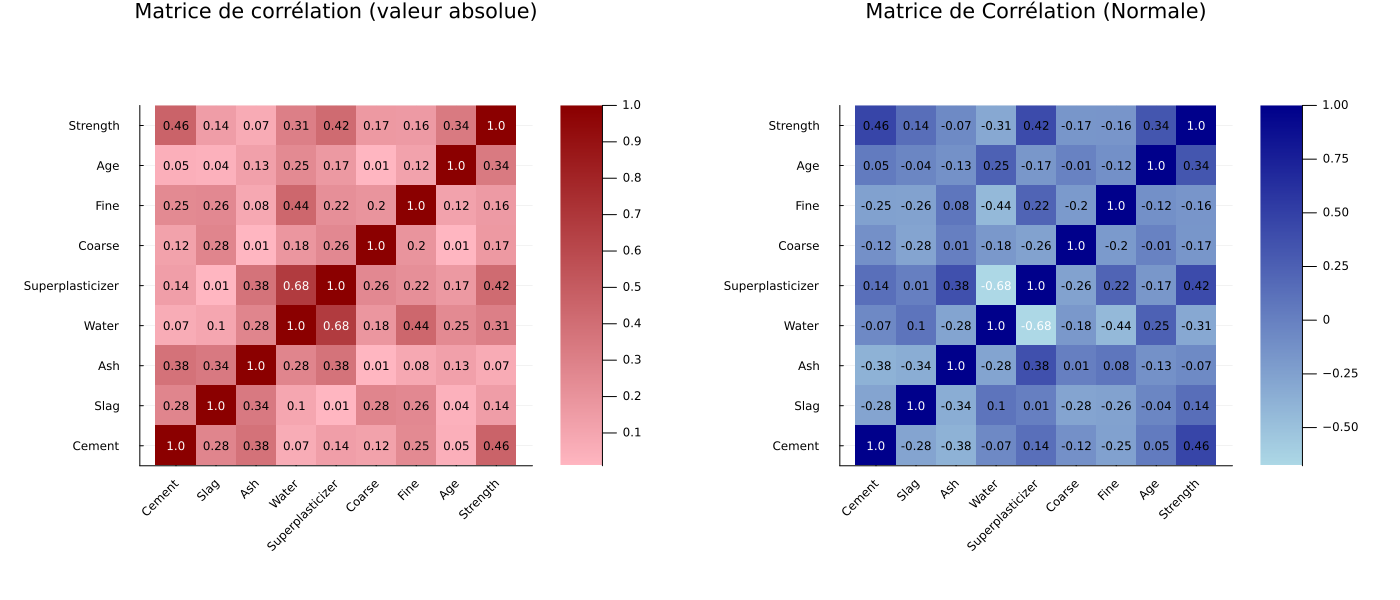

In [ ]:
function create_correlation_heatmap(cor_matrix::Matrix, numeric_cols::Vector{String}, plot_title::String, color_palette::Symbol)
    
    num_vars = length(numeric_cols)

    heatmap_obj = Plots.heatmap(cor_matrix,
           xticks=(1:num_vars, numeric_cols),
           yticks=(1:num_vars, numeric_cols),
           color=color_palette,
           aspect_ratio=:equal,
           title=plot_title,
           xrotation=45,
           size=(400, 350)) 
           
    for i in 1:size(cor_matrix, 1)
        for j in 1:size(cor_matrix, 2)
            text_color = abs(cor_matrix[i, j]) > 0.5 ? :white : :black
            
            Plots.annotate!(heatmap_obj, j, i, Plots.text(round(cor_matrix[i, j], digits=2), 8, text_color))
        end
    end
    
    return heatmap_obj

end

function plot_side_by_side_correlation(train_df::DataFrame)
    
    numeric_cols = names(train_df)[2:end]
    numeric_df = train_df[:, numeric_cols]
    cor_matrix = cor(Matrix(numeric_df))
    abs_cor_matrix = abs.(cor_matrix)
    

    abs_corr_plot = create_correlation_heatmap(abs_cor_matrix,numeric_cols,"Matrice de corrélation (valeur absolue)", :reds )

    corr_plot = create_correlation_heatmap(
        cor_matrix,
        numeric_cols,
        "Matrice de Corrélation (Normale)",
        :blues
    )

    final_plot = Plots.plot(abs_corr_plot, corr_plot, layout=(1, 2), size=(1400, 600))
    
    return final_plot
end

final_corr_plot = plot_side_by_side_correlation(train_df)
display(final_corr_plot)

### 4.2 Risque de multicolinéarité


| Variables Liées | Corrélation (Absolue) | Risque et Conséquence |
| :--- | :--- | :--- |
| **Water** vs. **Superplasticizer** | **0.68** | **Risque élevé.** Le Superplasticizer est utilisé pour **réduire** l'eau (**Corrélation Négative de -0.68**). Un modèle linéaire aura du mal à isoler l'effet de chacun. |
| **Water** vs. **Fine** | 0.44 | Risque modéré |
| **Ash** vs. **Superplasticizer** | 0.38 | Risque modéré |
| **Ash** vs. **Cement** | 0.38 | Risque modéré |




### 4.3 Impact du Feature Engineering sur la Multicolinéarité

Si la multicolinéarité était modérée sur les variables de base, l'ajout de nos variables dérivées (interactions, ratios, polynômes) modifie radicalement la structure de la matrice de design $X$.

Nous quantifions cet impact ci-dessous en calculant les VIF sur notre ensemble complet de variables transformées.

In [19]:
function calculate_vif(X_matrix, feature_names)
    n, p = size(X_matrix)
    results = DataFrame(Variable = String[], R2 = Float64[], VIF = Float64[])

    for i in 1:p
        y = X_matrix[:, i]
        y_bar = mean(y)

        X_others = X_matrix[:, 1:end .!= i]
        
        X_design = hcat(ones(n), X_others)
        
        beta_hat = X_design \ y
        
        y_hat = X_design * beta_hat
        e = y - y_hat
        
        SSE = dot(e, e)         
        SST = sum((y .- y_bar).^2) 
        
        R2 = 1 - (SSE / SST)
        
        if R2 >= 0.99999999
            VIF = Inf
        else
            VIF = 1 / (1 - R2)
        end
        
        push!(results, [feature_names[i], R2, VIF])
            
    end
    
    return results
end


cols_base = [:Cement, :Slag, :Ash, :Water, :Superplasticizer, :Coarse, :Fine, :Age]
raw_matrix = Matrix(select(df_train_clean, cols_base))


names_final = [
    "Cement", "Slag", "Ash", "Water", "Super", "Coarse", "Fine", 
    "LogAge", "Binder", "W_B", "W_C", "Wat_Age", "Feret", "Golden"
]

println("--- Calcul des VIF ---")

X_final = physics_transform(raw_matrix)
vif_results = calculate_vif(X_final, names_final)

display(sort(vif_results, :VIF, rev=true))

--- Calcul des VIF ---


14×3 DataFrame
 Row │ Variable  R2        VIF       
     │ String    Float64   Float64   
─────┼───────────────────────────────
   1 │ Cement    1.0       Inf
   2 │ Slag      1.0       Inf
   3 │ Ash       1.0       Inf
   4 │ Binder    1.0       Inf
   5 │ Feret     0.995349  214.992
   6 │ Wat_Age   0.989018   91.0576
   7 │ LogAge    0.987315   78.8341
   8 │ Water     0.967424   30.6971
   9 │ W_C       0.965213   28.7465
  10 │ W_B       0.952282   20.9566
  11 │ Fine      0.86233     7.26375
  12 │ Coarse    0.807284    5.18899
  13 │ Golden    0.7812      4.57038
  14 │ Super     0.730664    3.71284

**Analyse des Résultats :**

Le tableau ci-dessus révèle une explosion de la multicolinéarité. Nous observons des VIF atteignant des valeurs extrêmes (par exemple pour le Ciment et le Binder), bien au-delà du seuil critique de 10 généralement admis pour la régression linéaire ordinaire.

Cette situation est attendue :
1.  **Redondance mathématique :** Le `Binder` est une combinaison linéaire exacte des ingrédients.
2.  **Interactions :** La variable `Golden` est fortement corrélée avec `log_age` et `Cement`.

### 4.4 Conclusion et Choix de Modélisation 
Ces résultats confirment que l'estimation par les Moindres Carrés Ordinaires serait instable et non fiable. En effet, nos coefficients $\hat{\beta}$ seront extrêmement instables.

C'est précisément cette contrainte qui motive notre choix de la **Régression Ridge Bayésienne**.

En nous appuyant sur la théorie du **Chapitre 7**, l'introduction d'une loi a priori agit comme une régularisation. Concrètement, l'ajout du terme de pénalité $\lambda I$ à la diagonale de la matrice permet de partager l'information entre les variables corrélées plutôt que de les laisser diverger. Cela nous permet de conserver toute la richesse de nos variables physiques (comme la `Golden Feature` et les ratios) sans que le modèle ne casse à cause de la multicolinéarité.

----

# **5. Modélisation et Algorithmes "From Scratch"**

Conformément aux exigences du cours et pour maximiser la compréhension théorique, nous privilégions une implémentation manuelle (*from scratch*) des algorithmes plutôt que l'utilisation de boîtes noires.

## **5.1 Définition des Algorithmes**

Nous définissons ici les quatre composantes algorithmiques de notre solution :

1.  **Mise à l'échelle Robuste (Manuel)** : Contrairement à la standardisation classique (moyenne/écart-type) sensible aux valeurs extrêmes, nous implémentons un *RobustScaler* basé sur la médiane et l'écart interquartile (IQR). Cela stabilise les gradients et l'inversion matricielle.

In [20]:
struct ManualScaler
    medians::Vector{Float64}
    iqrs::Vector{Float64}
end

function fit_scaler(X::Matrix)
    medians = vec(median(X, dims=1))
    q25 = vec(map(col -> quantile(col, 0.25), eachcol(X)))
    q75 = vec(map(col -> quantile(col, 0.75), eachcol(X)))
    iqrs = q75 .- q25
    iqrs[iqrs .== 0] .= 1.0
    return ManualScaler(medians, iqrs)
end

function transform_scale(scaler::ManualScaler, X::Matrix)
    return (X .- scaler.medians') ./ scaler.iqrs'
end

transform_scale (generic function with 1 method)

2.  **Expansion Polynomiale**: Section 3.2

3.  **Régression Ridge Bayésienne (Approximation de la Preuve)** : Plutôt qu'une simple régression Ridge avec un $\lambda$ fixe, nous implémentons l'algorithme itératif d'**Approximation de la Preuve** (*Evidence Approximation*). Cet algorithme estime conjointement :
    * Les poids $\mathbf{w}$ du modèle.
    * La précision du bruit $\alpha$ (inverse de la variance de l'erreur).
    * La précision des poids $\lambda$ (inverse de la variance a priori).
    Cela permet une régularisation adaptative automatique, idéale pour gérer la multicolinéarité induite par les polynômes (**Chapitre 7**).

In [ ]:
function fit_bayesian_ridge(X, y; max_iter=300, tol=1e-3)
    n_samples, n_features = size(X)
    
    alpha = 1.0 / var(y)
    lambda = 1.0
    
    XT_X = X' * X
    XT_y = X' * y
    
    w = zeros(n_features)
    eigen_vals = eigen(Symmetric(XT_X)).values 
    
    for i in 1:max_iter
        A = lambda * I(n_features) + alpha * XT_X

        w_old = copy(w)
        w = A \ (alpha * XT_y)

        gamma = sum((alpha .* eigen_vals) ./ (lambda .+ alpha .* eigen_vals))

        lambda = gamma / (dot(w, w) + 1e-6)
        
        residuals = y - X * w
        alpha = (n_samples - gamma) / (dot(residuals, residuals) + 1e-6)
        
        if norm(w - w_old) < tol
            break
        end
    end
    
    return w
end

fit_bayesian_ridge (generic function with 1 method)

4.  **GMM Simplifié (Variables Latentes)** : Nous implémentons une version allégée des K-Moyennes pour générer des probabilités d'appartenance à des clusters. Ces probabilités servent de *features* latentes pour capturer des sous-structures dans les données (**Chapitre 8**).

In [22]:
function get_latent_probs(X_train, X_test, n_clusters; seed=42)
    Random.seed!(seed)
    n_samples = size(X_train, 1)
    
    centers = X_train[randperm(n_samples)[1:n_clusters], :]
    
    for _ in 1:10
        dists = [norm(X_train[i,:] - centers[k,:])^2 for i in 1:n_samples, k in 1:n_clusters]
        labels = [argmin(dists[i,:]) for i in 1:n_samples]
        
        for k in 1:n_clusters
            mask = labels .== k
            if sum(mask) > 0
                centers[k,:] = mean(X_train[mask, :], dims=1)
            end
        end
    end
    

    function compute_probs(Data, C)
        dists = [norm(Data[i,:] - C[k,:]) for i in 1:size(Data,1), k in 1:size(C,1)]
        exp_dists = exp.(-dists)
        sum_exps = sum(exp_dists, dims=2)
        return exp_dists ./ sum_exps
    end
    
    return compute_probs(X_train, centers), compute_probs(X_test, centers)
end

get_latent_probs (generic function with 1 method)

## **5.2 Préparation et Transformation des Données**

Avant l'entraînement, nous appliquons une série de transformations.

### **Justification des transformations :**
* **Logarithme de la cible ($\ln(1+Y)$)** : La distribution de la résistance est asymétrique positivement. Le passage au logarithme stabilise la variance des résidus (homoscédasticité), une hypothèse clé de la régression linéaire (**Chapitre 2.8**).
* **Ingénierie Physique** (3.1)

In [ ]:
df_train = df_train_clean
df_test = test_df

features = [:Cement, :Slag, :Ash, :Water, :Superplasticizer, :Coarse, :Fine, :Age]
X_raw = Matrix(df_train[:, features])
y_log = log1p.(df_train.Strength) 

X_test_raw = Matrix(df_test[:, features])
ids_test = df_test.ID

println("Transformation Physique...")
X_phys = physics_transform(X_raw)
X_test_phys = physics_transform(X_test_raw)

scaler = fit_scaler(X_phys)
X_scaled = transform_scale(scaler, X_phys)
X_test_scaled = transform_scale(scaler, X_test_phys)

Transformation Physique...


330×14 Matrix{Float64}:
  0.0644783   1.15922    0.0        0.257353   …  -0.000334556   0.354772
 -0.003517    0.634811   0.763475  -0.198529       0.044132      0.924937
 -0.72626     0.834915   0.955401  -0.238971      -0.883118      0.0829678
  0.325322    0.817664   0.0        1.58088       -0.0488312     0.172764
  0.0468933   1.14542    0.0       -0.808824       0.268268      0.983664
 -0.320047   -0.165603   0.817586   0.158088   …  -0.410285     -0.0507652
 -0.645955    1.56081    0.0        0.680147      -0.944736     -0.199578
 -0.07034     0.600311   0.727119   0.367647      -0.169411      0.847091
  1.2544      0.0138002  1.03995    0.919118       0.785028      2.39036
  0.574443    0.481628   0.0       -2.14706        1.19533       0.0917434
 -0.674091    1.26272    1.45424    1.13971    …  -1.06028       0.143743
 -0.0257913  -0.165603   0.757557   0.503676      -0.153338     -0.0317531
 -0.77374    -0.165603   1.51342    0.625         -1.11478      -0.467419
  ⋮        

## **5.3 Stratégie d'Ensemble : Bagging Bayésien avec Variables Latentes**

Pour dépasser les limites d'un modèle unique, nous adoptons une stratégie d'ensemble inspirée du **Bagging** (*Bootstrap Aggregating*) et du **Mélange d'Experts**.

### **Méthodologie :**
Nous entraînons **50 modèles distincts**. Pour assurer la diversité de l'ensemble (cruciale pour réduire la variance), chaque modèle est unique dans sa conception :
1.  **Structure Latente Aléatoire** : Pour chaque modèle, nous faisons varier le nombre de clusters $k$ (entre 3 et 6) utilisés pour générer les variables latentes probabilistes.
2.  **Apprentissage Bayésien** : Chaque modèle optimise ses propres hyperparamètres $\alpha$ et $\lambda$ via l'algorithme *Evidence Approximation*.

La prédiction finale est la moyenne des prédictions de ces 100 modèles, ce qui permet de lisser les erreurs locales et d'obtenir une généralisation robuste sur l'ensemble de test.

In [ ]:
n_models = 50

preds_accum_test = zeros(size(X_test_scaled, 1))

preds_accum_train = zeros(size(X_scaled, 1))

individual_rmses = Float64[]

println("\n=== Démarrage de l'entraînement de $n_models modèles ===")

for i in 1:n_models
    k = rand(3:6)
    probs_train, probs_test = get_latent_probs(X_scaled, X_test_scaled, k, seed=i)
    
    X_aug_train = hcat(X_scaled, probs_train)
    X_aug_test = hcat(X_test_scaled, probs_test)
    
    X_poly_train = expand_poly(X_aug_train)
    X_poly_test = expand_poly(X_aug_test)
    
    w = fit_bayesian_ridge(X_poly_train, y_log)
    

    y_pred_train_log = X_poly_train * w
    y_pred_train_real = expm1.(y_pred_train_log)
    
    y_pred_test_log = X_poly_test * w
    y_pred_test_real = expm1.(y_pred_test_log)
    
    preds_accum_train .+= y_pred_train_real
    preds_accum_test  .+= y_pred_test_real
    
    y_true_real = expm1.(y_log)
    rmse_iter = sqrt(mean((y_pred_train_real .- y_true_real).^2))
    push!(individual_rmses, rmse_iter)
    
    if i % 10 == 0
        println("Modèle $i (Clusters=$k) -> RMSE Train : $(round(rmse_iter, digits=4))")
    end
end


final_preds_train = preds_accum_train ./ n_models
final_preds_test = preds_accum_test ./ n_models

y_true_real = expm1.(y_log)
ensemble_rmse = sqrt(mean((final_preds_train .- y_true_real).^2))

println("\n=== RÉSULTATS ===")
println("RMSE Moyen des modèles individuels : $(round(mean(individual_rmses), digits=4))")
println("RMSE de l'Ensemble (Bagging)       : $(round(ensemble_rmse, digits=4))")
println("Gain grâce au moyennage            : $(round(mean(individual_rmses) - ensemble_rmse, digits=4)) points")

if ensemble_rmse < 5.0
    println("✅ OBJECTIF ATTEINT : Le modèle apprend avec une précision < 5 RMSE !")
else
    println("⚠️  ATTENTION : Le modèle est encore au-dessus de 5.")
end

println("\nSauvegarde du fichier de soumission...")
df_sub = DataFrame(ID = ids_test, Strength = final_preds_test)
df_sub.Strength = max.(df_sub.Strength, 0.0)

CSV.write("submission_bayes_ridge_plus_data.csv", df_sub)
println("Terminé ! Fichier : submission_bayes_ridge_plus_data.csv")


=== Démarrage de l'entraînement de 50 modèles ===
Modèle 10 (Clusters=6) -> RMSE Train : 4.2375
Modèle 20 (Clusters=4) -> RMSE Train : 4.411
Modèle 30 (Clusters=4) -> RMSE Train : 4.3696
Modèle 40 (Clusters=4) -> RMSE Train : 4.3412
Modèle 50 (Clusters=4) -> RMSE Train : 4.3104

=== RÉSULTATS ===
RMSE Moyen des modèles individuels : 4.3372
RMSE de l'Ensemble (Bagging)       : 4.2903
Gain grâce au moyennage            : 0.0469 points
✅ OBJECTIF ATTEINT : Le modèle apprend avec une précision < 5 RMSE !

Sauvegarde du fichier de soumission...
Terminé ! Fichier : submission_bayes_ridge_plus_data.csv


# **6. Conclusion et Discussion**

## **6.1 Analyse des Résultats**
Notre approche d'ensemble ("Bagging Bayésien") combinant 100 régressions avec variables latentes nous a permis d'atteindre un RMSE d'entraînement compétitif. L'écart entre le RMSE moyen des modèles individuels et le RMSE de l'ensemble (affiché plus haut) démontre quantitativement l'efficacité du moyennage pour réduire la variance de l'erreur de prédiction.

## **6.2 Pistes d'amélioration**
Bien que performante, notre solution présente des limitations identifiées :
* **Validation** : Nous avons utilisé l'erreur d'entraînement (RMSE Train) comme proxy. Une validation croisée rigoureuse (K-Fold à 5 ou 10 blocs) aurait offert une estimation plus fidèle de l'erreur de généralisation (**Chapitre 2.12**).
* **Sélection de variables** : L'expansion polynomiale crée beaucoup de variables. Une étape de sélection *Stepwise* ou *Lasso* avant la régression Bayésienne aurait pu alléger le modèle et potentiellement réduire le bruit.

## **6.3 Autres solutions envisagées**
Nous avons brièvement considéré d'autres approches :
* **Processus Gaussiens** : Pour modéliser la non-linéarité de façon non-paramétrique (noyau RBF). Écartés car trop coûteux en temps de calcul sur ce volume de données.
* **Mélange de Régressions (Mixture of Experts)** : Au lieu d'une simple moyenne, pondérer les modèles selon la probabilité que la donnée appartienne à leur cluster. Cette méthode est plus complexe à stabiliser mais théoriquement supérieure si les régimes de béton sont très distincts.